In [1]:
import os, sys
sys.path.append("src/")
os.environ["CUDA_VISIBLE_DEVICES"] = "0,"
from pathlib import Path
from types import SimpleNamespace
import math
import numpy as np
from einops import rearrange
from PIL import Image, ImageDraw
import torch

from musubi_tuner.dataset.image_video_dataset import resize_image_to_bucket
from musubi_tuner.networks import lora_framepack
from musubi_tuner.frame_pack.uni_pc_fm import sample_unipc
from musubi_tuner.frame_pack.wrapper import fm_wrapper
from musubi_tuner.frame_pack.clip_vision import hf_clip_vision_encode
from musubi_tuner.frame_pack.framepack_utils import load_vae, load_text_encoder1, load_text_encoder2, load_image_encoders
from musubi_tuner.frame_pack.hunyuan import encode_prompt_conds, vae_encode, vae_decode
from musubi_tuner.frame_pack.hunyuan_video_packed import load_packed_model
from musubi_tuner.frame_pack.utils import crop_or_pad_yield_mask
from musubi_tuner.wan_generate_video import merge_lora_weights

# sys.path.append("../../../utils")
# from pose_detection.dwpose import DwposeDetector

device = torch.device('cuda')

2025-07-20 18:28:30.293514: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753003710.311915   34269 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753003710.317625   34269 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-20 18:28:30.336326: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
INFO:numexpr.utils:Note: detected 96 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment 

Xformers is installed!
Flash Attn is installed!
Sage Attn is installed!
Trying to import sageattention
Successfully imported sageattention


In [2]:
dit_path = "/data/stale/patrickkwon/video/stable-diffusion-webui/models/Hunyuan/FramePackI2V_HY_bf16.safetensors"
vae_path = "/data/stale/patrickkwon/video/stable-diffusion-webui/models/VAE/hunyuan-video-t2v-720p-vae.pt"
text_encoder1_path = "/shared/video/ComfyUI/models/text_encoders/llava_llama3_fp16.safetensors"
text_encoder2_path = "/shared/video/ComfyUI/models/text_encoders/clip_l.safetensors"
image_encoder_path = "/shared/video/ComfyUI/models/clip_vision/sigclip_vision_patch14_384.safetensors"
lora_path = "/data/whisperer/related/framepackbase/musubi-tuner/outputs/training/posecontrol_lora/posecontrol_lora_test2.safetensors"

model = load_packed_model(device, dit_path, 'sageattn', device)
model.to(device)
model.eval().requires_grad_(False)

if lora_path != '':
    merge_lora_weights(lora_framepack, model, 
        SimpleNamespace(
            lora_weight = [lora_path], 
            lora_multiplier = [1.0], 
            include_patterns=None, 
            exclude_patterns=None, 
            lycoris=None,
            save_merged_model=False), 
    device, None)

vae = load_vae(vae_path, 32, 128, device)

tokenizer1, text_encoder1 = load_text_encoder1(SimpleNamespace(text_encoder1=text_encoder1_path), False, device)
tokenizer2, text_encoder2 = load_text_encoder2(SimpleNamespace(text_encoder2=text_encoder2_path))
feature_extractor, image_encoder = load_image_encoders(SimpleNamespace(image_encoder=image_encoder_path))


# dwpose_model = DwposeDetector.from_pretrained(
#     '/shared/video/ComfyUI/custom_nodes/comfyui_controlnet_aux/ckpts/hr16/DWPose-TorchScript-BatchSize5',
#     '/shared/video/ComfyUI/custom_nodes/comfyui_controlnet_aux/ckpts/hr16/yolox-onnx',
#     det_filename='yolox_l.torchscript.pt', 
#     pose_filename='dw-ll_ucoco_384_bs5.torchscript.pt',
#     torchscript_device='cuda:0'
# )

INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Creating HunyuanVideoTransformer3DModelPacked
INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Loading DiT model from /data/stale/patrickkwon/video/stable-diffusion-webui/models/Hunyuan/FramePackI2V_HY_bf16.safetensors, device=cuda
INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Loaded DiT model from /data/stale/patrickkwon/video/stable-diffusion-webui/models/Hunyuan/FramePackI2V_HY_bf16.safetensors, info=<All keys matched successfully>
INFO:musubi_tuner.wan_generate_video:Loading LoRA weights from /data/whisperer/related/framepackbase/musubi-tuner/outputs/training/posecontrol_lora/posecontrol_lora_test2.safetensors with multiplier 1.0
INFO:musubi_tuner.networks.lora:create LoRA network from weights
INFO:musubi_tuner.networks.lora:create LoRA for U-Net/DiT: 440 modules.
INFO:musubi_tuner.networks.lora:weights are merged
INFO:musubi_tuner.wan_generate_video:LoRA weights loaded
INFO:musubi_tuner.hunyuan_model.vae:Loading 3D VAE model (

In [15]:
# prompt = 'Dancing tiktok video'
# image_path = '/data/whisperer/datasets/pose/tiktok_train/controls/cond1/00059_images_0178.png'
# control_image_paths = [
#     '/data/whisperer/datasets/pose/tiktok_train/controls/cond1/00059_images_0178.png',
#     '/data/whisperer/datasets/pose/tiktok_train/controls/cond3/00059_images_0202.png'
# ]

# prompt = 'Eating a hamburger inside macdonalds, Dancing tiktok video'
# image_path = "/data/ai-video/datasets/AnimeDrawingsDataset/images_raw/train/1164056.png"
# control_image_paths = [
#     "/data/ai-video/datasets/AnimeDrawingsDataset/images_raw/train/1164056.png",
#     '/data/whisperer/datasets/pose/tiktok_train/controls/cond3/00012_images_0301.png'
# ]
in_folder = Path("/data/whisperer/outputs/20250717_154812/[PANEL-3]")
prompt = (in_folder / "prompt.txt").read_text() + ", Dancing tiktok video"
# image_path = str(in_folder / "chara_img.png")
image_path = "/data/whisperer/datasets/storyviz/ViStoryBench/ViStoryBench/10/image/Mr. Qin/00.jpg"
# control_image_paths = [str(in_folder / "chara_img.png"), str(in_folder / "skeleton_img.png")]
control_image_paths = ["/data/whisperer/datasets/storyviz/ViStoryBench/ViStoryBench/10/image/Mr. Qin/00.jpg", str(in_folder / "skeleton_img.png")]

control_image_mask_paths = ["", ""]
control_indices = [0,10]
target_index = [9]

  0%|          | 0/25 [00:00<?, ?it/s]

tensor([[[-0.1660, -0.1943, -1.0312,  ...,  0.2188, -0.0137, -0.5156],
         [ 0.3867,  0.2500,  0.5938,  ..., -0.7969, -0.1118, -0.0664],
         [-0.2100, -0.4277,  0.1406,  ..., -0.2676, -0.2412, -0.2021],
         ...,
         [-0.2100, -0.1582, -0.0393,  ..., -0.0703,  0.1699, -0.3730],
         [ 0.3223,  0.0168, -0.5312,  ...,  0.7617, -0.3438, -0.1592],
         [-0.4863, -0.2832, -0.0559,  ..., -0.4160, -0.1680,  0.3184]]],
       device='cuda:0', dtype=torch.bfloat16)
tensor([[[-0.9111, -0.9111, -0.2108,  ...,  0.0000,  0.0000,  0.0000],
         [-0.9111, -0.9111, -0.2108,  ...,  0.0058,  0.0048,  0.0048],
         [-0.9111, -0.9111, -0.2108,  ...,  0.0116,  0.0095,  0.0095],
         ...,
         [-0.9111, -0.9111, -0.2108,  ...,  0.1561,  0.1282,  0.1282],
         [-0.9111, -0.9111, -0.2108,  ...,  0.1618,  0.1329,  0.1329],
         [-0.9111, -0.9111, -0.2108,  ...,  0.1675,  0.1377,  0.1377]]],
       device='cuda:0')
tensor([[[[[ 1.0938,  1.1094,  1.2031,  ...,  

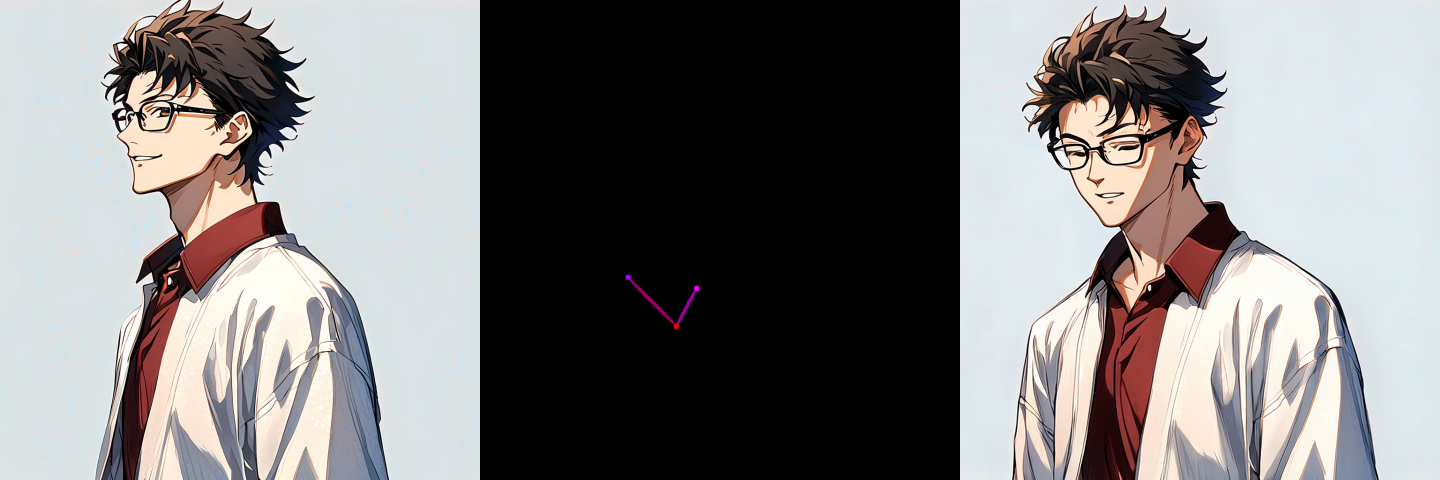

In [16]:
## Text Preprocessing

with torch.autocast(device_type=device.type, dtype=text_encoder1.dtype), torch.no_grad():
    llama_vec, clip_l_pooler = encode_prompt_conds(
        prompt, text_encoder1, text_encoder2, tokenizer1, tokenizer2, custom_system_prompt=None
    )
    llama_vec = llama_vec.to(device, dtype=torch.bfloat16)
    clip_l_pooler = clip_l_pooler.to(device, dtype=torch.bfloat16)
    llama_vec, llama_attention_mask = crop_or_pad_yield_mask(llama_vec, length=512)

llama_vec_n = torch.zeros_like(llama_vec).to(device, dtype=torch.bfloat16)
clip_l_pooler_n  = torch.zeros_like(clip_l_pooler).to(device, dtype=torch.bfloat16)
llama_vec_n, llama_attention_mask_n = crop_or_pad_yield_mask(llama_vec_n, length=512)

## Image Preprocessing
og_width, og_height = Image.open(image_path).size
height = math.sqrt(480*480 / (og_width / og_height))
width = 480*480 / height
height, width = int(round(height / 16) * 16), int(round(width / 16) * 16)

def preproc_image(image_path):
    image_pil = Image.open(image_path).convert("RGB")
    image_np = resize_image_to_bucket(np.array(image_pil), (width, height))
    image_tensor = (torch.from_numpy(image_np).float() / 127.5 - 1.0).permute(2,0,1)[None, :, None]
    return image_tensor, image_np

def preproc_mask(mask_path):
    if mask_path == '':
        image_pil = Image.new("L", (width // 8, height // 8), 255)
    else:
        image_pil = Image.open(mask_path).convert("L")
    image_np = resize_image_to_bucket(np.array(image_pil), (width // 8, height // 8))
    image_tensor = (torch.from_numpy(image_np).float() / 255.0)[None, None, None, :, :]
    return image_tensor, image_np

img_tensor, img_np = preproc_image(image_path)
with torch.no_grad():
    image_encoder_output = hf_clip_vision_encode(img_np, feature_extractor, image_encoder)
image_encoder_last_hidden_state = image_encoder_output.last_hidden_state.to(device, dtype=torch.bfloat16)
# start_latent = vae_encode(img_tensor, vae).cpu()
latent_indices = torch.tensor([target_index], dtype=torch.int64)  # 1x1 latent index for target image

control_latents, control_nps = [], []
for i, (control_image_path, control_mask_path) in enumerate(zip(control_image_paths, control_image_mask_paths)):
    c_img_tensor, c_img_np = preproc_image(control_image_path)
    c_img_latent = vae_encode(c_img_tensor, vae).cpu()
    
    c_mask_image, c_mask_np = preproc_mask(control_mask_path)
    c_img_latent = c_img_latent * c_mask_image
    control_latents.append(c_img_latent)
    control_nps.append(np.concatenate([c_img_np, resize_image_to_bucket(c_mask_np, (width, height))[..., None]], -1))
clean_latents = torch.cat(control_latents, dim=2)  # (1, 16, num_control_images, H//8, W//8)

clean_latent_indices = torch.tensor([control_indices], dtype=torch.int64)

## sample_hunyuan
def flux_time_shift(t, mu=1.15, sigma=1.0):
    return math.exp(mu) / (math.exp(mu) + (1 / t - 1) ** sigma)

def calculate_flux_mu(context_length, x1=256, y1=0.5, x2=4096, y2=1.15, exp_max=7.0):
    k = (y2 - y1) / (x2 - x1)
    b = y1 - k * x1
    mu = k * context_length + b
    mu = min(mu, math.log(exp_max))
    return mu

def get_flux_sigmas_from_mu(n, mu):
    sigmas = torch.linspace(1, 0, steps=n + 1)
    sigmas = flux_time_shift(sigmas, mu=mu)
    return sigmas

real_guidance_scale=1.0
distilled_guidance_scale=10.0
guidance_rescale=0.0
num_inference_steps=25
seed = 192
generator = torch.Generator(device="cpu")
generator.manual_seed(seed)

latents = torch.randn((1, 16, 1, height // 8, width // 8), generator=generator).to(device=device, dtype=torch.float32)
seq_length = (height * width) // 256
mu = calculate_flux_mu(seq_length, exp_max=7.0) # math.log(shift) 1.9459... if seq_len is large, mu is clipped.
sigmas = get_flux_sigmas_from_mu(num_inference_steps, mu).to(device)

k_model = fm_wrapper(model)

distilled_guidance = torch.tensor([distilled_guidance_scale * 1000.0]).to(device=device, dtype=torch.bfloat16)
sampler_kwargs = dict(
    dtype=torch.bfloat16,
    cfg_scale=real_guidance_scale,
    cfg_rescale=guidance_rescale,
    concat_latent=None,
    positive=dict(
        pooled_projections=clip_l_pooler,
        encoder_hidden_states=llama_vec,
        encoder_attention_mask=llama_attention_mask,
        guidance=distilled_guidance,

        image_embeddings=image_encoder_last_hidden_state,
        latent_indices=latent_indices,
        clean_latents=clean_latents,
        clean_latent_indices=clean_latent_indices,
        clean_latents_2x=None,
        clean_latent_2x_indices=None,
        clean_latents_4x=None,
        clean_latent_4x_indices=None
    ),
    negative=dict(
        pooled_projections=clip_l_pooler_n,
        encoder_hidden_states=llama_vec_n,
        encoder_attention_mask=llama_attention_mask_n,
        guidance=distilled_guidance,

        image_embeddings=image_encoder_last_hidden_state,
        latent_indices=latent_indices,
        clean_latents=clean_latents,
        clean_latent_indices=clean_latent_indices,
        clean_latents_2x=None,
        clean_latent_2x_indices=None,
        clean_latents_4x=None,
        clean_latent_4x_indices=None
    ),
)

results = sample_unipc(k_model, latents, sigmas, extra_args=sampler_kwargs, disable=False, callback=None)

history_pixels = torch.cat([
    vae_decode(results[:, :, i:i + 1, :, :], vae).cpu() for i in range(results.shape[2])
], dim=2)
result_img = (torch.clamp(((history_pixels[0,:,0,:,:]+1.0)/2.0).permute(1,2,0).cpu(), 0.0, 1.0) * 255.).numpy().astype(np.uint8)
result_img = np.concatenate([result_img, np.ones(result_img.shape[:2] + (1, ))*255], axis=-1).astype(np.uint8)

Image.fromarray(np.concatenate(control_nps + [result_img], axis=1))